In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur=conn.cursor()

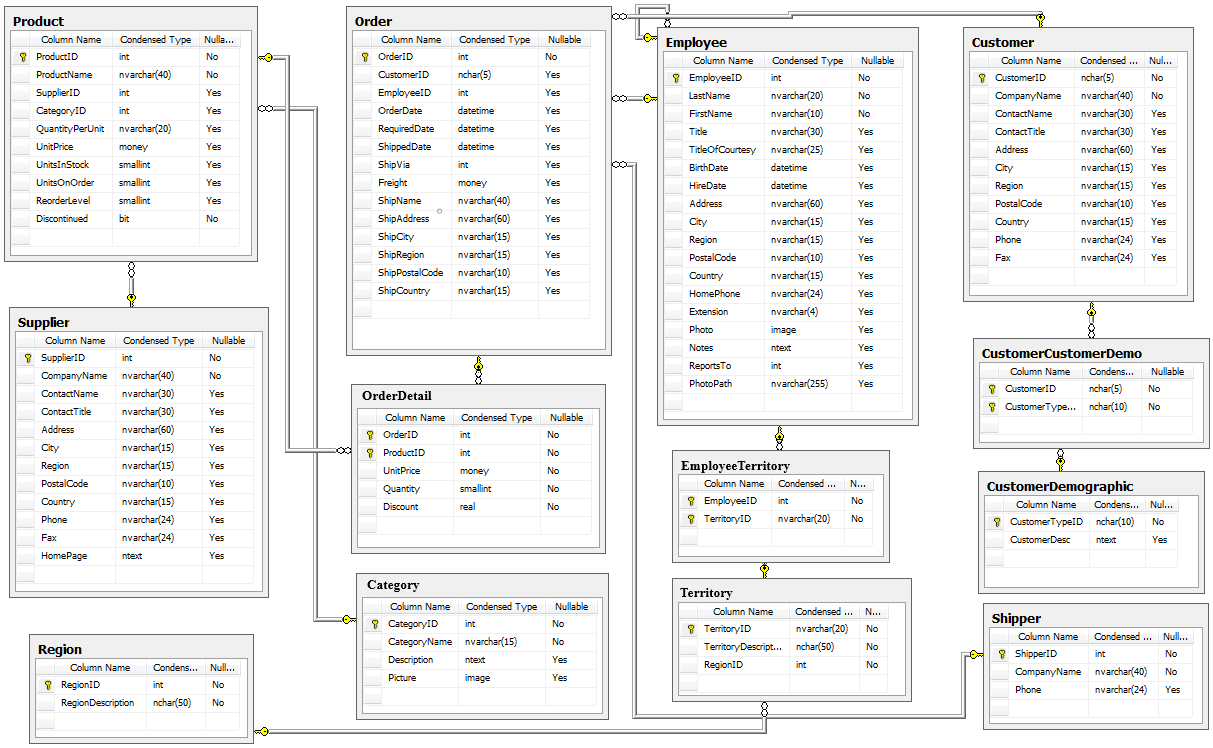

In [4]:
from PIL import Image
erd = Image.open('Northwind_ERD_updated.png')
erd

In [4]:
cur.execute("""SELECT name 
               FROM sqlite_master
               WHERE type = 'table'""").fetchall()
# this gives us the names of the each table

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

# Hypothesis Testing: 1

## Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Hypothesis:
- H0: Discount amount does not have a statistically significant effect on the quantity of a product in an order.
- Ha: Discount amount does have a statistically significant effect on the quantity of a product in an order.

In [3]:
# This shows how many different discounts we have -- 10 ranging from no discount (0) to 25%
cur.execute("""SELECT DISTINCT(Discount)
               FROM OrderDetail
               ORDER BY Discount ASC
               """)
df_a = pd.DataFrame(cur.fetchall())
df_a.columns = [x[0] for x in cur.description]
df_a.head(2)

,Discount
0,0.00
1,0.01


In [4]:
# this shows just everything that is in the table for OrderDetail
cur.execute("""SELECT *
               FROM OrderDetail
               """)
df_b = pd.DataFrame(cur.fetchall())
df_b.columns = [x[0] for x in cur.description]
display(df_b.head(2))
len(df_b)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248/11,10248,11,14.0,12,0.0,None
1,10248/42,10248,42,9.8,10,0.0,None


2155

We're trying to see if having a discount effects the quantity of an order.  We need to compare having a discount (what we want) to not having a discount (the null hypothesis)
- H0: mu_nodiscount = mu_discount
- Ha: mu_nodiscount != mu_discount

In [5]:
# This shows how many of each discount there is.  
# The majority of the orders have no discount
cur.execute("""Select Discount, SUM(Quantity) 
               FROM OrderDetail
               GROUP BY Discount
               ORDER BY Discount""")
df_c = pd.DataFrame(cur.fetchall())
df_c.columns = [x[0] for x in cur.description]
df_c.head(2)

,Discount,SUM(Quantity)
0,0.00,28599
1,0.01,2


In [6]:
# this tells us all ther orders that do not have a discount 
# There are 1317 total, but some of the OrderId's are repeating.
cur.execute("""Select *
               FROM OrderDetail
               WHERE Discount = 0""")
df_d = pd.DataFrame(cur.fetchall())
df_d.columns = [x[0] for x in cur.description]
display(df_d.head(2))
print(len(df_d))

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248/11,10248,11,14.0,12,0.0,None
1,10248/42,10248,42,9.8,10,0.0,None


1317


In [7]:
# This shows us all the orders that have a discount
# There is a total of 838
cur.execute("""Select *
               FROM OrderDetail
               WHERE Discount > 0""")
df_e = pd.DataFrame(cur.fetchall())
df_e.columns = [x[0] for x in cur.description]
display(df_e.head(2))
print(len(df_e))

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10250/51,10250,51,42.4,35,0.15,None
1,10250/65,10250,65,16.8,15,0.15,None


838


In [10]:
# checking to see if we still have the same number of data from the original, the answer is yes
1317+838

2155

In [8]:
# This gives us all the orderid's as one, showing the total quantity that they had purchased, then averaged their 
# discount
cur.execute("""SELECT OrderId, Sum(Quantity) as quantity, AVG(Discount) as discount 
            FROM OrderDetail
            GROUP BY OrderId""")
df_f = pd.DataFrame(cur.fetchall())
df_f.columns = [x[0] for x in cur.description]
df_f.head(2)

,OrderId,quantity,discount
0,10248,27,0.0
1,10249,49,0.0


In [12]:
# want to compare the ones that have a discount and the ones that do not have discount
df_nodiscount = df_f[df_f['discount']==0]
df_discount = df_f[df_f['discount']!=0]

In [13]:
# the question is asking if the discount has an effect on quantity. 
# we have separated the data to see the average discount that people received on their purchases between having a
# discount or not
# then from those we want to see if it effect the quantity, we we are using only the quantity portion of the
# no discount, discount tables
nodiscount = df_nodiscount['quantity']
discount = df_discount['quantity']
display(nodiscount.head())

0     27
1     49
5    102
7    110
8     27
Name: quantity, dtype: int64

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


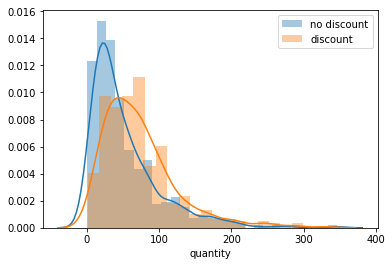

In [14]:
# this shows the distribution of each one in one plot
# we can see that they are right skewed - this give us a non parametric distribution
sns.distplot(nodiscount, label='no discount')
sns.distplot(discount, label='discount')
plt.legend()

In [15]:
# two sample t-test
stats.ttest_ind(a,b)

NameError: name 'a' is not defined

In [16]:
# use the mann whitney to find the p-value, it is the same as the t-test just for non parametric distributions
stats.mannwhitneyu(discount, nodiscount)
# we reject the null because the p-value is less than alpha = 0.05 confidence level of 95%
# the means of discount and no discount are different
# discount does have an effect

MannwhitneyuResult(statistic=59105.0, pvalue=8.524065415288705e-15)

In [17]:
# if you get significant results (a p-value that rejects the null) you want to find the effect size
from numpy import mean, sqrt, std
def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return np.abs((mean(x) - mean(y))/sqrt(((nx-1)*std(x,ddof=1)**2+(ny-1)*std(y, ddof=1)**2)/dof))

In [19]:
effect_size = cohen_d_two_samp(discount, nodiscount)
effect_size
# the effect size is .4 which means that we have a small effect on the mean outcome

0.41225480363635514

In [21]:
from statsmodels.stats.power import tt_ind_solve_power
tt_ind_solve_power(effect_size, len(df_f), 0.05)

1.0

### Conclusion on discount amount having a statistically significant effect on the quantity of a product in an order:
After separating the data between having a discount and having no discount, in relation to the quantity of the products purchased, there showed to be a difference between the means with a p-value that was less that the 0.05, after using the Mann Whitney Test.  Therefore we can say that with 95% confidence that there is a significant difference between the means, discount does have an effect on quantity of a product order.  The effect size was .4, which lets us know that it is a small effect though.

Since having a discount does effect quantity of a product in an order, we want to make sure that when we test to see where the effect is which the discounts only. 

Next steps would be to find where the differences lie by using ANOVA from the original data (with the 0 discounts dropped) to find which particular level of discount is effecting.  Our target variable is Quantity and the feature variable is Discount.

The new hypothesis is:
- H0: Discounts have no effect on each other
- Ha: At least one discount has an effect

In [9]:
just_discounts = df_b[df_b['Discount']!=0]
display(just_discounts.head(2))
len(just_discounts)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
6,10250/51,10250,51,42.4,35,0.15,None
7,10250/65,10250,65,16.8,15,0.15,None


838

In [17]:
# next step use one way ANOVA find different levels of discount
sm.stats.anova_lm(ols('Quantity ~ Discount', data=just_discounts).fit())
# the p-value is greater than the alpha of .05, therefore there is no significant difference between the
# the levels of discounts.  We fail to reject the null.

,df,sum_sq,mean_sq,F,PR(>F)
Discount,1.0,381.770455,381.770455,0.884727,0.347182
Residual,836.0,360744.129306,431.512116,NaN,NaN


### Conclusion on at what level(s) of discount has an effect quantity:

After running the ANOVA testing on the data with no discount data dropped, so that we may only compare the discounts.  It shows that no particular discount has an effect on the quantity of order.  The p-value is greater than our alpha of .05, therefore we fail to reject the null.